In [1]:
# Environment Variables: 

YES = 1
NO = 0

# Google Drive:
using_google_drive = NO

if using_google_drive:
    from google.colab import drive
    drive.mount('/content/drive')

In [1]:
# Imports

import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.preprocessing import StandardScaler
from scipy.optimize import least_squares
from dask import delayed, compute
from dask.distributed import Client
from tqdm import tqdm
import tensorflow as tf
import hls4ml

# %matplotlib inline
output_scaler = StandardScaler()
print(tf.config.list_physical_devices('GPU'))

np.random.seed(0)
tf.random.set_seed(0)

ModuleNotFoundError: No module named 'dask'

# To load data

In [3]:
# Read H5 Data File:
DATA_DIR = 'data' # Change to your DATA PATH

RHEED_DATA_FILE = DATA_DIR + '/RHEED_4848_test6.h5'
spot = 'spot_2'
h5 = h5py.File(RHEED_DATA_FILE, 'r')

raw_data = []
for growth in h5.keys():
    raw_data.extend(h5[growth][spot])
raw_data = np.array(raw_data).astype(np.float32)

normalized_images = []
for image in raw_data:
    normalized_images.append(image / np.max(image))
normalized_images = np.array(normalized_images).astype(np.float32)

print(f'[Normalized Images Shape]: {normalized_images.shape}')

[Normalized Images Shape]: (150985, 48, 48)


[Normalized Image #43567]:


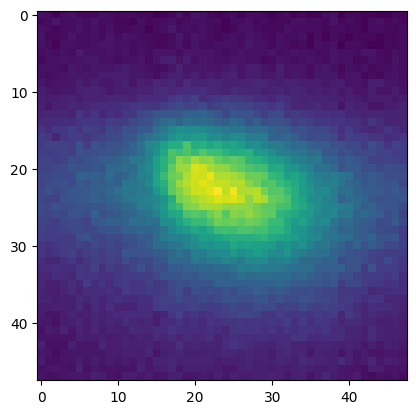

In [4]:
# Validate Data Array:
validate_data_array = YES

if validate_data_array:
    rand_int = np.random.randint(low=0, high=normalized_images.shape[0])
    print(f'[Normalized Image #{rand_int}]:')
    plt.imshow(normalized_images[rand_int])

In [5]:
# Functions for estimating labels

# generate 2d Gaussian from its parameters
# x, y = x-coord, y-coord
# A = amplitude
# x0, y0 = mean-x, mean-y
# sigma_x, sigma_y = std.-dev.-x, std.-dev.-y
def gaussian_2D(x, y, A, x0, y0, sigma_x, sigma_y):
    return A * np.exp(-((x - x0)**2 / (2 * sigma_x**2) + (y - y0)**2 / (2 * sigma_y**2)))

# Initial guess for each parameter
# data = normalized image
def add_guess(data):
    A_guess = np.max(data)
    x0_guess, y0_guess = np.unravel_index(np.argmax(data), data.shape)
    sigma_x_guess = sigma_y_guess = np.std(data)
    return [A_guess, x0_guess, y0_guess, sigma_x_guess, sigma_y_guess]

# Compute residuals
# params = A, x0, y0, sigma_x, sigma_y
# x, y  = x-coord, y-coord
# data = normalized image
def residuals(params, x, y, data):
    A, x0, y0, sigma_x, sigma_y = params
    model = gaussian_2D(x, y, A, x0, y0, sigma_x, sigma_y)
    return (model - data).ravel()

# Convert parameters from A, x0, y0, sigma_x, sigma_y --> mean_x, mean_y, cov_x, cov_y, theta
# params = A, x0, y0, sigma_x, sigma_y
def convert_parameters(parameters):
    A, x0, y0, sigma_x, sigma_y = parameters
    mean_x = x0
    mean_y = y0
    cov_x = sigma_x
    cov_y = sigma_y

    if cov_x != 0 and cov_y != 0:
        theta = 0.5 * np.arctan(2 * cov_x * cov_y / (cov_x**2 - cov_y**2)+1e-9)
    else:
        theta = 0.0

    return mean_x, mean_y, cov_x, cov_y, theta

@delayed
def fit_gaussian_2D_delayed(data, guess):
    y, x = np.indices(data.shape)
    result = least_squares(residuals, guess, args=(x, y, data))
    return result.x


In [6]:
# Estimate Labels:
load_labels = YES # (Takes <1 min to load, ~40 mins to generate)

# Import From File
if load_labels:
    file_path = ''
    # estimated_labels = np.load(file_path)
    estimated_labels = np.random.rand(normalized_images.shape[0], 5)

# Generate
else:
    estimated_labels = []
    with Client() as client:
        guesses = [add_guess(image) for image in normalized_images]
        fits = [fit_gaussian_2D_delayed(image, guess) for image, guess in zip(normalized_images, guesses)]
        estimated_labels = [convert_parameters(params) for params in compute(*fits)]
    estimated_labels = np.array(estimated_labels).astype(np.float32)

print(f'[Estimated Labels Shape]: {estimated_labels.shape}')

[Estimated Labels Shape]: (150985, 5)


In [7]:
# Create DataSet:
batch_size = 1000

with tf.device('CPU'):
    dataset = tf.data.Dataset.from_tensor_slices(normalized_images)
    dataset = dataset.shuffle(normalized_images.shape[0], reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)

output_scaler.fit(estimated_labels)

2024-11-21 14:56:27.948324: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


StandardScaler()

In [8]:
# Gaussian Function: (TENSORFLOW)
print_example_guassian = NO

# mean_x, mean_y, cov_x, cov_y, theta
def generate_guassian(batch, image_shape):
    batch_size = batch.shape[0]
    mean_x, mean_y, cov_x, cov_y, theta = tf.unstack(batch, axis=-1)
    x = tf.range(image_shape[1], dtype=tf.float32)[:, tf.newaxis]
    x = tf.tile(x, [1, image_shape[0]])

    y = tf.range(image_shape[0], dtype=tf.float32)[tf.newaxis, :]
    y = tf.tile(y, [image_shape[1], 1])

    x = tf.tile(tf.expand_dims(x, 0), [batch_size, 1, 1])
    y = tf.tile(tf.expand_dims(y, 0), [batch_size, 1, 1])

    rota_matrix = tf.stack([tf.cos(theta), -tf.sin(theta), tf.sin(theta), tf.cos(theta)], axis=-1)
    rota_matrix = tf.reshape(rota_matrix, (batch_size, 2, 2))

    xy = tf.stack([x - tf.reshape(mean_x, (-1, 1, 1)), y - tf.reshape(mean_y, (-1, 1, 1))], axis=-1)
    xy = tf.einsum('bijk,bkl->bijl', xy, rota_matrix)

    img = tf.exp(-0.5 * (xy[:, :, :, 0]**2 / tf.reshape(cov_x, (-1, 1, 1))**2 + xy[:, :, :, 1]**2 / tf.reshape(cov_y, (-1, 1, 1))**2))

    return tf.expand_dims(img, axis=1)

if print_example_guassian:
    image_shape = (48, 48)
    batch = tf.convert_to_tensor([
        [21.8558168, 24.50041009, 10.31268177, 9.1700225, 0.72681534]
        , [21.76068143, 24.37956637, 10.30043488, 9.15426013, 0.72655111]
        , [21.72363929, 24.31050759, 10.33800891, 9.18570812, 0.72644599]
        , [21.72777699, 24.29306623, 10.30178808, 9.14728058, 0.72610718]
        , [21.79849472, 24.34649405, 10.32683150, 9.16259293, 0.72573213]
    ])
    generated_imgs = generate_guassian(batch, image_shape)
    plt.imshow(tf.squeeze(generated_imgs[0]))
    plt.show()

In [14]:
# Custom Loss Function (TENSORFLOW):
print_example_loss = YES

def custom_weighted_mse_loss(I, J, n):
  W = tf.pow(I, n)

  squared_diffs = tf.pow(I - J, 2)

  weighted_squared_diffs = W * squared_diffs

  loss = tf.reduce_mean(weighted_squared_diffs)

  return loss

if print_example_loss:
  I = tf.random.normal((5, 1, 48, 48))
  J = tf.random.normal((5, 1, 48, 48))
  n = 2
  loss = custom_weighted_mse_loss(I, J, n)
  print("[Custom Weighted MSE Loss]:", loss.numpy())

[Custom Weighted MSE Loss]: 3.7529922


# Large model (won't convert)

In [15]:
# Model Architecture

model = tf.keras.Sequential(
    [   
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', input_shape=(48, 48, 1)) # (batch_size, height, width, channels)
        , tf.keras.layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05)
        , tf.keras.layers.ReLU()
        , tf.keras.layers.MaxPool2D(pool_size=4, strides=4)

        , tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='valid')
        , tf.keras.layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05)
        , tf.keras.layers.ReLU()
        , tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

        , tf.keras.layers.Flatten()
        , tf.keras.layers.Dense(units=98, activation='relu')
        , tf.keras.layers.Dense(units=52, activation='relu')
        , tf.keras.layers.Dense(units=5)
    ]
)

model.compile(optimizer='adam', loss=custom_weighted_mse_loss)

In [17]:
# Training Loop
train_model = YES
save_model = YES
load_model = YES

if train_model:
    best_loss = float('inf')
    num_epochs = 1
    lr = 0.0001
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    n = 1

    for epoch in range(num_epochs):
        running_loss = 0.0

        if epoch % 10 == 0:
            n += 0.1

        for image_batch in tqdm(dataset): 
            image_batch = tf.expand_dims(image_batch, axis=3) # (batch_size, height, width, channels)
            with tf.GradientTape() as tape:
                embedding = model(image_batch)
                unscaled_param = tf.constant(embedding * output_scaler.var_ ** 0.5 + output_scaler.mean_)
                final = generate_guassian(unscaled_param, (48,48))
                loss = custom_weighted_mse_loss(image_batch, final, n)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            running_loss += loss.numpy()
        average_loss = running_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")
else:
    model = tf.keras.models.load_model("GaussianModel.keras")
    # pass

if save_model:
    model.save("GaussianModel.keras")



model.summary()

100%|██████████| 151/151 [01:46<00:00,  1.42it/s]

Epoch [1/1], Loss: 0.07773980616733728
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 44, 44, 6)         156       
                                                                 
 batch_normalization_2 (Batc  (None, 44, 44, 6)        176       
 hNormalization)                                                 
                                                                 
 re_lu_2 (ReLU)              (None, 44, 44, 6)         0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 6)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 16)          2416      
                                                                 
 batch_normaliz

In [18]:
# Generate the configuration from the Keras model
config = hls4ml.utils.config_from_keras_model(model)

# Print out the config to debug and check for unwanted settings
print(config)

# Attempt conversion on simplified model
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_1/hls4ml_prj', part='xcu250-figd2104-2L-e'
)

Interpreting Sequential
Topology:
Layer name: conv2d_2_input, layer type: InputLayer, input shapes: [[None, 48, 48, 1]], output shape: [None, 48, 48, 1]
Layer name: conv2d_2, layer type: Conv2D, input shapes: [[None, 48, 48, 1]], output shape: [None, 44, 44, 6]
Layer name: batch_normalization_2, layer type: BatchNormalization, input shapes: [[None, 44, 44, 6]], output shape: [None, 44, 44, 6]
Layer name: re_lu_2, layer type: Activation, input shapes: [[None, 44, 44, 6]], output shape: [None, 44, 44, 6]
Layer name: max_pooling2d_2, layer type: MaxPooling2D, input shapes: [[None, 44, 44, 6]], output shape: [None, 11, 11, 6]
Layer name: conv2d_3, layer type: Conv2D, input shapes: [[None, 11, 11, 6]], output shape: [None, 7, 7, 16]
Layer name: batch_normalization_3, layer type: BatchNormalization, input shapes: [[None, 7, 7, 16]], output shape: [None, 7, 7, 16]
Layer name: re_lu_3, layer type: Activation, input shapes: [[None, 7, 7, 16]], output shape: [None, 7, 7, 16]
Layer name: max_pool

ValueError: operands could not be broadcast together with shapes (44,) (5,5,1,6) 

In [ ]:
hls_model.build(csim=0)

# Smaller model, does convert

In [19]:
model2 = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', input_shape=(48, 48, 1)),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPool2D(pool_size=4, strides=4),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=98, activation='relu'),
        tf.keras.layers.Dense(units=5, activation='softmax')
    ]
)

model2.compile(optimizer='adam', loss=custom_weighted_mse_loss)

In [20]:
# Training Loop
train_model = YES
save_model = YES
load_model = NO

if train_model:
    best_loss = float('inf')
    num_epochs = 1
    lr = 0.0001
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    n = 1

    for epoch in range(num_epochs):
        running_loss = 0.0

        if epoch % 10 == 0:
            n += 0.1

        for image_batch in tqdm(dataset): 
            image_batch = tf.expand_dims(image_batch, axis=3) # (batch_size, height, width, channels)
            with tf.GradientTape() as tape:
                embedding = model2(image_batch)
                unscaled_param = tf.constant(embedding * output_scaler.var_ ** 0.5 + output_scaler.mean_)
                final = generate_guassian(unscaled_param, (48,48))
                loss = custom_weighted_mse_loss(image_batch, final, n)
            grads = tape.gradient(loss, model2.trainable_variables)
            optimizer.apply_gradients(zip(grads, model2.trainable_variables))

            running_loss += loss.numpy()
        average_loss = running_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")

if save_model:
    model2.save("GaussianModel2.keras")

if load_model:
    pass

model2.summary()

100%|██████████| 151/151 [02:21<00:00,  1.06it/s]

Epoch [1/1], Loss: 0.07774685555143862
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 44, 44, 6)         156       
                                                                 
 re_lu_4 (ReLU)              (None, 44, 44, 6)         0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 11, 11, 6)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 726)               0         
                                                                 
 dense_6 (Dense)             (None, 98)                71246     
                                                                 
 dense_7 (Dense)             (None, 5)                 495       
               

In [21]:
# Generate the configuration from the Keras model
config2 = hls4ml.utils.config_from_keras_model(model2)

# Print out the config to debug and check for unwanted settings
print(config2)

# Attempt conversion on simplified model
hls_model2 = hls4ml.converters.convert_from_keras_model(
    model2, hls_config=config2, output_dir='model_2/hls4ml_prj', part='xcu250-figd2104-2L-e'
)

Interpreting Sequential
Topology:
Layer name: conv2d_4_input, layer type: InputLayer, input shapes: [[None, 48, 48, 1]], output shape: [None, 48, 48, 1]
Layer name: conv2d_4, layer type: Conv2D, input shapes: [[None, 48, 48, 1]], output shape: [None, 44, 44, 6]
Layer name: re_lu_4, layer type: Activation, input shapes: [[None, 44, 44, 6]], output shape: [None, 44, 44, 6]
Layer name: max_pooling2d_4, layer type: MaxPooling2D, input shapes: [[None, 44, 44, 6]], output shape: [None, 11, 11, 6]
Layer name: flatten_2, layer type: Reshape, input shapes: [[None, 11, 11, 6]], output shape: [None, 726]
Layer name: dense_6, layer type: Dense, input shapes: [[None, 726]], output shape: [None, 98]
Layer name: dense_7, layer type: Dense, input shapes: [[None, 98]], output shape: [None, 5]
{'Model': {'Precision': {'default': 'fixed<16,6>'}, 'ReuseFactor': 1, 'Strategy': 'Latency', 'BramFactor': 1000000000, 'TraceOutput': False}}
Interpreting Sequential
Topology:
Layer name: conv2d_4_input, layer typ

In [ ]:
hls_model2.build(csim=0)

Writing HLS project
Done

****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2019.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2019.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'aelabd' on host 'DESKTOP-Q0UCNGC.' (Linux_x86_64 version 5.15.133.1-microsoft-standard-WSL2) on Thu Nov 21 14:55:29 PST 2024
INFO: [HLS 200-10] On os Ubuntu 24.04 LTS
INFO: [HLS 200-10] In directory '/home/aelabd/RHEED/Rheed-GaussianModel/model_2/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/aelabd/RHEED/Rheed-GaussianModel/model_2/hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10] Adding te

# Other large model
Same architecture as first large model but not tf.Sequential

In [24]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class CropLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(CropLayer, self).__init__(**kwargs)

    def call(self, inputs):
        image, crop_boxes = inputs
        batch_size = tf.shape(image)[0]
        num_boxes = tf.shape(crop_boxes)[1]
        crop_boxes = tf.reshape(crop_boxes, (batch_size * num_boxes, 4))  # Flatten the crop_boxes tensor
        box_indices = tf.range(batch_size)
        box_indices = tf.repeat(box_indices, repeats=num_boxes)
        
        cropped_images = tf.image.crop_and_resize(
            image, crop_boxes, box_indices, (20, 20)
        )
        
        return cropped_images

def build_cnn_with_gaussian_prediction(input_shape):
    # Input layer
    inputs = layers.Input(shape=input_shape)
   
    # Initial convolutions to process the full image
    x = layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='valid')(inputs) # (batch_size, height, width, channels)
    x = layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05)(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=4, strides=4)(x)

    x = layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='valid')(x)
    x = layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05)(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(units=98, activation='relu')(x)
    x = layers.Dense(units=52, activation='relu')(x)
    x = layers.Dense(units=5)(x)

    #got rid of crop_pred output
    model = Model(inputs=inputs, outputs=x)
    return model

# Example usage
input_shape = (48, 48, 1)
model3 = build_cnn_with_gaussian_prediction(input_shape)
model3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 44, 44, 6)         156       
                                                                 
 batch_normalization_6 (Batc  (None, 44, 44, 6)        176       
 hNormalization)                                                 
                                                                 
 re_lu_7 (ReLU)              (None, 44, 44, 6)         0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 11, 11, 6)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 16)          2416

In [25]:
# Training Loop
train_model = YES
save_model = YES
load_model = NO

if train_model:
    best_loss = float('inf')
    num_epochs = 1
    lr = 0.0001
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    n = 1

    for epoch in range(num_epochs):
        running_loss = 0.0

        if epoch % 10 == 0:
            n += 0.1

        for image_batch in tqdm(dataset): 
            image_batch = tf.expand_dims(image_batch, axis=3) # (batch_size, height, width, channels)
            with tf.GradientTape() as tape:
                embedding = model3(image_batch)
                unscaled_param = tf.constant(embedding * output_scaler.var_ ** 0.5 + output_scaler.mean_)
                final = generate_guassian(unscaled_param, (48,48))
                loss = custom_weighted_mse_loss(image_batch, final, n)
            grads = tape.gradient(loss, model3.trainable_variables)
            optimizer.apply_gradients(zip(grads, model3.trainable_variables))

            running_loss += loss.numpy()
        average_loss = running_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")

if save_model:
    model3.save("GaussianModel3.keras")

if load_model:
    pass

model3.summary()

100%|██████████| 151/151 [01:40<00:00,  1.50it/s]

Epoch [1/1], Loss: 0.07773976708879533
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 44, 44, 6)         156       
                                                                 
 batch_normalization_6 (Batc  (None, 44, 44, 6)        176       
 hNormalization)                                                 
                                                                 
 re_lu_7 (ReLU)              (None, 44, 44, 6)         0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 11, 11, 6)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)  

In [26]:
# Generate the configuration from the Keras model
config3 = hls4ml.utils.config_from_keras_model(model3)

# Print out the config to debug and check for unwanted settings
print(config3)

# Attempt conversion on simplified model
hls_model3 = hls4ml.converters.convert_from_keras_model(
    model3, hls_config=config3, output_dir='model_3/hls4ml_prj', part='xcu250-figd2104-2L-e'
)

Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 48, 48, 1]], output shape: [None, 48, 48, 1]
Layer name: conv2d_7, layer type: Conv2D, input shapes: [[None, 48, 48, 1]], output shape: [None, 44, 44, 6]
Layer name: batch_normalization_6, layer type: BatchNormalization, input shapes: [[None, 44, 44, 6]], output shape: [None, 44, 44, 6]
Layer name: re_lu_7, layer type: Activation, input shapes: [[None, 44, 44, 6]], output shape: [None, 44, 44, 6]
Layer name: max_pooling2d_7, layer type: MaxPooling2D, input shapes: [[None, 44, 44, 6]], output shape: [None, 11, 11, 6]
Layer name: conv2d_8, layer type: Conv2D, input shapes: [[None, 11, 11, 6]], output shape: [None, 7, 7, 16]
Layer name: batch_normalization_7, layer type: BatchNormalization, input shapes: [[None, 7, 7, 16]], output shape: [None, 7, 7, 16]
Layer name: re_lu_8, layer type: Activation, input shapes: [[None, 7, 7, 16]], output shape: [None, 7, 7, 16]
Layer name: max_pooling2d_8, lay

ValueError: operands could not be broadcast together with shapes (44,) (5,5,1,6) 

In [ ]:
hls_model3.build(csim=0)

# Generate some benchmarking data

In [ ]:
# Set-Up for Benchmarking:
avg_params = np.mean(estimated_labels, axis=0) # output_scaler.mean_ ?
std_params = np.std(estimated_labels, axis=0) # output_scaler.var_ ?

In [23]:
# Generate Plausible Gaussians:
num_generated_gaussians = 1000

generated_gaussians_labels = []
for num in range(num_generated_gaussians):
    new_gaussian_label = []
    for (avg, std) in zip(avg_params, std_params):
        new_gaussian_label.append(avg + np.random.normal(loc=0, scale=std))
    generated_gaussians_labels.append(new_gaussian_label)
generated_gaussians_labels = np.array(generated_gaussians_labels)

generated_gaussians_images = generate_guassian(tf.convert_to_tensor(generated_gaussians_labels, dtype=tf.float32), (48,48))

print(f'[Generated Gaussian Labels Shape]: {generated_gaussians_labels.shape}')
print(f'[Generated Guassian Images Shape]: {generated_gaussians_images.shape}')

[Generated Gaussian Labels Shape]: (1000, 5)
[Generated Guassian Images Shape]: (1000, 1, 48, 48)
